# ARGALI improved

https://www.researchgate.net/publication/224158277_Optic_Disc_Region_of_Interest_Localization_in_Fundus_Image_for_Glaucoma_Detection_in_ARGALI

In [1]:
import cv2
import numpy as np

# Open the image
image = cv2.imread('JustRAIGS_Train/TRAIN044138.JPG')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Flatten the image and get the indices of the brightest 0.5% pixels
num_pixels = gray_image.shape[0] * gray_image.shape[1]
flatten_image = gray_image.flatten()
sorted_indices = np.argsort(flatten_image)
brightest_indices = sorted_indices[-int(num_pixels * 0.005):]

# Reshape the indices to recover their coordinates
brightest_coords = np.column_stack(np.unravel_index(brightest_indices, gray_image.shape))

# Divide the image into an 8x8 grid
grid_height = gray_image.shape[0] // 8
grid_width = gray_image.shape[1] // 8

# Count the amount of selected pixels in each grid
grid_counts = np.zeros((8, 8), dtype=int)
for coord in brightest_coords:
    grid_row = coord[0] // grid_height
    grid_col = coord[1] // grid_width
    grid_counts[grid_row][grid_col] += 1

# Find the grid with the highest amount of brightest pixels
max_count = np.max(grid_counts)
max_count_indices = np.argwhere(grid_counts == max_count)
max_count_grid = max_count_indices[0]

# Calculate the centroid of the brightest pixels in the grid with the highest count
centroid_x = 0
centroid_y = 0
count = 0
for coord in brightest_coords:
    grid_row = coord[0] // grid_height
    grid_col = coord[1] // grid_width
    if grid_row == max_count_grid[0] and grid_col == max_count_grid[1]:
        centroid_x += coord[1]
        centroid_y += coord[0]
        count += 1

centroid_x /= count
centroid_y /= count

print("Centroid of the brightest pixels in the grid with the highest count:", (centroid_x, centroid_y))


Centroid of the brightest pixels in the grid with the highest count: (3410.4285778893336, 1720.9441014856523)


# ROI using Transform

https://link.springer.com/article/10.1007/s11517-020-02237-2
https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/iet-ipr.2019.0137

In [2]:
visualize_extract = True
save_extract = True
visualize_crop = True

In [3]:
import cv2
import numpy as np

# Open the image
image = cv2.imread('JustRAIGS_Train/TRAIN095523.JPG')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Perform top-hat and bottom-hat transform
kernel_size = (100,100)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
tophat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, kernel)
bottomhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)

# Combine the original image with the top-hat and bottom-hat transforms
enhanced_image = cv2.add(gray_image, tophat)
enhanced_image = cv2.subtract(enhanced_image, bottomhat)

# Flatten the image array to 1D
flattened_image = enhanced_image.flatten()

# Sort the flattened array in descending order
sorted_values = np.sort(flattened_image)[::-1]

# Determine the threshold value
threshold_index = int(len(sorted_values) * 0.065)
threshold_value = sorted_values[threshold_index]

# Create a binary mask of pixels above the threshold
mask = (enhanced_image >= threshold_value).astype(np.uint8)

# Mask the original image to retain only the top 6.5% brightest pixels
brightest_region = enhanced_image * mask

# Extract the green channel
green_channel = image[:, :, 1]

# Apply CLAHE on the green channel
# clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
clahe = cv2.createCLAHE()
clahe_green = clahe.apply(green_channel)

# Perform bottom-hat transform on the green channel
nerve_tophat = cv2.morphologyEx(clahe_green, cv2.MORPH_TOPHAT, kernel)
nerve_bottomhat = cv2.morphologyEx(clahe_green, cv2.MORPH_BLACKHAT, kernel)

# segmented_nerve_image = cv2.subtract(nerve_tophat, nerve_bottomhat)
nerve_image = cv2.subtract(nerve_bottomhat, nerve_tophat)

# Combine segmented nerve with enhanced
combined_image = cv2.add(brightest_region, nerve_image)

# Resize images for display
resize = lambda a : cv2.resize(a, (0,0), fx= 0.3, fy=0.3)

if visualize_extract:
    # Display the original, enhanced, and segmented images
    cv2.imshow('Original Image', resize(image))
    cv2.imshow('Grayscaled Image', resize(gray_image))
    cv2.imshow('Top Hat', resize(tophat))
    cv2.imshow('Bottom Hat', resize(bottomhat))
    cv2.imshow('Enhanced Image', resize(enhanced_image))
    cv2.imshow('Brightest Region', resize(brightest_region))
    cv2.imshow('Green Channel', resize(green_channel))
    cv2.imshow('Green Channel CLAHE', resize(clahe_green))
    cv2.imshow('CLAHE Top Hat', resize(nerve_tophat))
    cv2.imshow('CLAHE Bottom Hat', resize(nerve_bottomhat))
    cv2.imshow('Nerve Image', resize(nerve_image))
    cv2.imshow('Combined Image', resize(combined_image))
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [4]:
# Untuk Visualisasi
# Define the directory to save the resized images
save_dir = 'Ekstraksi Fitur/'

# Save the resized images to files
if save_extract :
    cv2.imwrite(save_dir + 'Original_Image.jpg', resize(image))
    cv2.imwrite(save_dir + 'Grayscaled_Image.jpg', resize(gray_image))
    cv2.imwrite(save_dir + 'Top_Hat.jpg', resize(tophat))
    cv2.imwrite(save_dir + 'Bottom_Hat.jpg', resize(bottomhat))
    cv2.imwrite(save_dir + 'Enhanced_Image.jpg', resize(enhanced_image))
    cv2.imwrite(save_dir + 'Brightest_Region.jpg', resize(brightest_region))
    cv2.imwrite(save_dir + 'Green_Channel.jpg', resize(green_channel))
    cv2.imwrite(save_dir + 'Green_Channel_CLAHE.jpg', resize(clahe_green))
    cv2.imwrite(save_dir + 'CLAHE_Top_Hat.jpg', resize(nerve_tophat))
    cv2.imwrite(save_dir + 'CLAHE_Bottom_Hat.jpg', resize(nerve_bottomhat))
    cv2.imwrite(save_dir + 'Nerve_Image.jpg', resize(nerve_image))
    cv2.imwrite(save_dir + 'Combined_Image.jpg', resize(combined_image))

In [5]:
# Function to perform sliding window and calculate average intensity
def sliding_window_avg(image, window_size, stride):
    height, width = image.shape
    padding_y = window_size[0] // 2
    padding_x = window_size[1] // 2
    
    end_y = height - padding_y 
    end_x = width - padding_x
    result = np.empty(image.shape)

    # Iterate through the image with the sliding window
    for y in range(padding_y, end_y, stride):
        for x in range(padding_x, end_x, stride):
            # Calculate the coordinates of the center of the window
            center_y = y + padding_y
            center_x = x + padding_x

            # Adjust the window boundaries based on the center coordinates
            window_y_start = max(0, center_y - padding_y)
            window_y_end = min(height, center_y + padding_y)
            window_x_start = max(0, center_x - padding_x)
            window_x_end = min(width, center_x + padding_x)

            window = image[window_y_start:window_y_end, window_x_start:window_x_end]
            result[center_y, center_x] = np.mean(window)

    return result

In [6]:
# Define window size for sliding window
window_size = (250, 250)
stride = 300 

In [7]:
# Calculate average intensity for each image
avg_intensity_brightest_region = sliding_window_avg(brightest_region, window_size, stride)
avg_intensity_segmented = sliding_window_avg(nerve_image, window_size, stride)
avg_intensity_combined = sliding_window_avg(combined_image, window_size, stride)

In [8]:
enhanced_normalized = (avg_intensity_brightest_region - np.min(avg_intensity_brightest_region)) / (np.max(avg_intensity_brightest_region) - np.min(avg_intensity_brightest_region))
segmented_normalized = (avg_intensity_segmented - np.min(avg_intensity_segmented)) / (np.max(avg_intensity_segmented) - np.min(avg_intensity_segmented))
combined_normalized = (avg_intensity_combined - np.min(avg_intensity_combined)) / (np.max(avg_intensity_combined) - np.min(avg_intensity_combined))

In [9]:
summed_of_all = enhanced_normalized + segmented_normalized + combined_normalized
avg_of_all = summed_of_all / 3

In [10]:
# Find the index of the highest value
max_index = np.argmax(avg_of_all)

# Convert the flattened index to 2D index
max_index_2d = np.unravel_index(max_index, avg_of_all.shape)
print(f"max sliding window location (y, x) : {max_index_2d}")

max sliding window location (y, x) : (550, 1150)


In [12]:
# Specify the center coordinates
center_y, center_x = max_index_2d

crop_size = 3 * window_size[0]
right_bias = 0
bottom_bias = 0

# Calculate the top-left corner coordinates of the crop region
top_left_x = max(0, center_x - crop_size//2 + right_bias)
top_left_y = max(0, center_y - crop_size//2 + bottom_bias)

# Calculate the bottom-right corner coordinates of the crop region
bottom_right_x = min(image.shape[1], center_x + crop_size//2 + right_bias)
bottom_right_y = min(image.shape[0], center_y + crop_size//2 + bottom_bias)

# Crop the image
cropped_image = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

# Resize the cropped image to 800x800 if necessary
cropped_image = cv2.resize(cropped_image, (crop_size, crop_size))

if visualize_crop :
    # Display the cropped image
    cv2.imshow('Cropped Image', cropped_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Visualisasi

MovieWriter imagemagick unavailable; using Pillow instead.


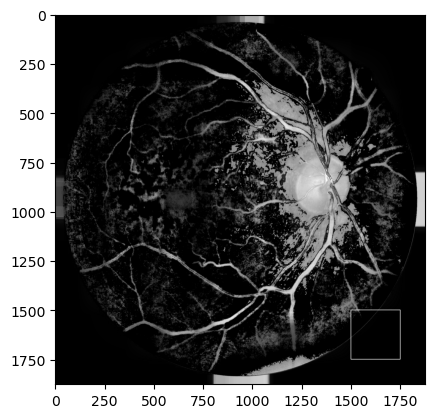

In [13]:
#Visualisasi Sliding window

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load the image
animation_image = combined_image

# Initialize the animation
# Create a list to store images for animation
animation_frames = []

# Perform sliding window and create animation frames
for i in range(0, animation_image.shape[0] - window_size[0] + 1, stride):
    for j in range(0, animation_image.shape[1] - window_size[1] + 1, stride):
        # Create a copy of the original animation_image
        temp_image = animation_image.copy()
        
        # Draw the sliding window on the copy
        cv2.rectangle(temp_image, (j, i), (j + window_size[1], i + window_size[0]), (255, 255, 255), 2)
        
        # Append the frame to the list
        animation_frames.append(temp_image)

# Create animation
fig = plt.figure()
ims = [[plt.imshow(frame, cmap='gray', animated=True)] for frame in animation_frames]
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

# Save the animation as GIF
ani.save('sliding_window_animation.gif', writer='imagemagick')

plt.show()